# Overview

Welcome to my notebook on the competition House Prices - Advanced Regression Techniques !

For this competition I will work in 4 phases :

* Phase 1 : Quick & Dirty Modelisation
* Phase 2 : Modelisation with the best correlated variables
* Phase 3 : Feature Engineering (get back the less-correlated variables with interaction effects)
* Phase 4 : Apply advanced techniques


The scores I have obtained with RMSE are :
* Phase 1 : 0.15329 (V13)
* Phase 2 : 
* Phase 3 : 
* Phase 4 :


Special thanks to :
* @adibouayjan, I learnt a lot of snippets, especially for phase 2 in dataviz & modelization : https://www.kaggle.com/code/adibouayjan/house-price-step-by-step-modeling/notebook

# Preliminaries - Import libraries, functions & data

> My math teacher said it : like all the good things, you need preliminaries.

## Import libraries and specific functions from libraries

In [241]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

from sklearn.metrics import mean_squared_error   # RMSE : mean_squared_error(y_true, y_pred, squared=False)

from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score



## Create generic functions

In [95]:
# Got this function in Kaggle course
def score_dataset(X, y, model=XGBRegressor(random_state=0)):
    # Label encoding for categoricals
    #for colname in X.select_dtypes(["category", "object"]):
    #    X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSE
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_root_mean_squared_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

## Read the dataset

In [151]:
# Read datasets
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col="Id")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv", index_col="Id")

# Store index for purposes
train_index = train.index
test_index = test.index

In [152]:
train.head()

Int64Index([1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470,
            ...
            2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919],
           dtype='int64', name='Id', length=1459)

## For each numerical column : should it be a catgorical variable ? If yes, convert.

For each column, I refer to the documentation to know exactly about the business value of the column.

In [146]:
print(train.columns[(train.dtypes=="float64") | (train.dtypes=="int64")])
# 37 numerical features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


In [148]:
# The only conversion I identified is : MSSubclass - Encoded nominative categorical variable - Identifies the type of dwelling involved in the sale.
# As I have the mapping table mentioned in the data description, I will use it directly.

lookup_MSSubclass = pd.DataFrame( \
[ \
  {'MSSubClass' : 20, 'MSSubClass_label' : '20 - 1-STORY 1946 & NEWER ALL STYLES'} \
, {'MSSubClass' : 30, 'MSSubClass_label' : '30 - 1-STORY 1945 & OLDER'} \
, {'MSSubClass' : 40, 'MSSubClass_label' : '40 - 1-STORY W/FINISHED ATTIC ALL AGES'} \
, {'MSSubClass' : 45, 'MSSubClass_label' : '45 - 1-1/2 STORY - UNFINISHED ALL AGES'} \
, {'MSSubClass' : 50, 'MSSubClass_label' : '50 - 1-1/2 STORY FINISHED ALL AGES'} \
, {'MSSubClass' : 60, 'MSSubClass_label' : '60 - 2-STORY 1946 & NEWER'} \
, {'MSSubClass' : 70, 'MSSubClass_label' : '70 - 2-STORY 1945 & OLDER'} \
, {'MSSubClass' : 75, 'MSSubClass_label' : '75 - 2-1/2 STORY ALL AGES'} \
, {'MSSubClass' : 80, 'MSSubClass_label' : '80 - SPLIT OR MULTI-LEVEL'} \
, {'MSSubClass' : 85, 'MSSubClass_label' : '85 - SPLIT FOYER'} \
, {'MSSubClass' : 90, 'MSSubClass_label' : '90 - DUPLEX - ALL STYLES AND AGES'} \
, {'MSSubClass' : 120, 'MSSubClass_label' : '120 - 1-STORY PUD (Planned Unit Development) - 1946 & NEWER'} \
, {'MSSubClass' : 150, 'MSSubClass_label' : '150 - 1-1/2 STORY PUD - ALL AGES'} \
, {'MSSubClass' : 160, 'MSSubClass_label' : '160 - 2-STORY PUD - 1946 & NEWER'} \
, {'MSSubClass' : 180, 'MSSubClass_label' : '180 - PUD - MULTILEVEL - INCL SPLIT LEV/FOYER'} \
, {'MSSubClass' : 190, 'MSSubClass_label' : '190 - 2 FAMILY CONVERSION - ALL STYLES AND AGES'} \
] \
)

In [149]:
print(train.shape)
train = pd.merge(train, lookup_MSSubclass, on='MSSubClass', how='left')
print(train.shape)
# No generation of rows : it's ok !

print(test.shape)
test = pd.merge(test, lookup_MSSubclass, on='MSSubClass', how='left')
print(test.shape)
# No generation of rows : it's ok !

(1460, 80)
(1460, 81)
(1459, 79)
(1459, 80)


In [101]:
print("Number of NAs should be equal :")
print("")
print(train[['MSSubClass', 'MSSubClass_label']].isnull().sum())
print("")
print("Verify the mapping on a few rows :")
print(train[['MSSubClass', 'MSSubClass_label']].head(20))

Number of NAs should be equal :

MSSubClass          0
MSSubClass_label    0
dtype: int64

Verify the mapping on a few rows :
    MSSubClass                                 MSSubClass_label
0           60                        60 - 2-STORY 1946 & NEWER
1           20             20 - 1-STORY 1946 & NEWER ALL STYLES
2           60                        60 - 2-STORY 1946 & NEWER
3           70                        70 - 2-STORY 1945 & OLDER
4           60                        60 - 2-STORY 1946 & NEWER
5           50               50 - 1-1/2 STORY FINISHED ALL AGES
6           20             20 - 1-STORY 1946 & NEWER ALL STYLES
7           60                        60 - 2-STORY 1946 & NEWER
8           50               50 - 1-1/2 STORY FINISHED ALL AGES
9          190  190 - 2 FAMILY CONVERSION - ALL STYLES AND AGES
10          20             20 - 1-STORY 1946 & NEWER ALL STYLES
11          60                        60 - 2-STORY 1946 & NEWER
12          20             20 - 1-STORY 19

In [102]:
# All is good : finally drop the MSSubClass column, we will use MSSubClass_label instead.
train = train.drop(['MSSubClass'], axis=1)
test = test.drop(['MSSubClass'], axis=1)

In [103]:
# Just lo let you know, in order to facilitate the construction of the script above, I take each line :

"""
        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        ...
"""

# And convert each line with this regex :
"""
        (\d*)\t(.*)
        , {'MSSubClass' : \1, 'MSSubClass_label' : '\1 - \2'} \
"""

# It could have been mapped with a file or a table in a database, and it is what I would have done in a production context.

print("")

## Create some useful lists

In [135]:
features_object = train.columns[train.dtypes=="object"]
features_numeric = train.columns[(train.dtypes=="float64") | (train.dtypes=="int64")]

features_numeric = features_numeric[:-1]  # Remove SalePrice

# PHASE 1 : Quick & Dirty Modelisation

> Placeholder - Why ?

Now that data has been imported, let's take some time in order to explore it.

## Generic informations

In [105]:
# Size of the dataset ?
print(train.shape) # 1460 rows, 80 columns
print("\n")

# Repartition of type of data ?
print(train.dtypes.value_counts()) # 44 string, 33 int64, 3 float64. Most of categorical variables.

(1460, 80)


object     44
int64      33
float64     3
dtype: int64


## I'm curious about the number of modalites in categorical variables. Let's take a look.

In [106]:
train[features_object].nunique().sort_values(ascending=False)
# Seems that there is not a lot variable with a lof of different values.
# If we decide to keep it, we will probably be needed to work on Neighborhood ; Exterior2nd ; MSSubClass_label ; Exterior1st

Neighborhood        25
Exterior2nd         16
MSSubClass_label    15
Exterior1st         15
Condition1           9
SaleType             9
RoofMatl             8
HouseStyle           8
Condition2           8
Functional           7
BsmtFinType1         6
GarageType           6
RoofStyle            6
SaleCondition        6
Heating              6
Foundation           6
BsmtFinType2         6
FireplaceQu          5
GarageQual           5
GarageCond           5
Electrical           5
HeatingQC            5
MSZoning             5
LotConfig            5
BldgType             5
ExterCond            5
LotShape             4
MiscFeature          4
Fence                4
LandContour          4
BsmtExposure         4
KitchenQual          4
MasVnrType           4
ExterQual            4
BsmtQual             4
BsmtCond             4
LandSlope            3
GarageFinish         3
PavedDrive           3
PoolQC               3
Street               2
Utilities            2
CentralAir           2
Alley      

In [107]:
print(train.Neighborhood.unique())
print(train.Exterior2nd.unique())
print(train.Exterior1st.unique())

['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone'
 'Other' 'CBlock']
['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']


## Where are the missing values ?

In [108]:
count_na = (train.isnull().sum())
types_na = train[count_na.index].dtypes
ratio_na = round((count_na / train.shape[0]) * 100, 2)

missing_val_count_by_column = pd.concat([count_na, ratio_na, types_na], axis=1)
missing_val_count_by_column.columns = ["count_na", "ratio_na", "types_na"]

print(missing_val_count_by_column[missing_val_count_by_column.count_na > 0].sort_values(by=["ratio_na"], ascending=False))

# Some features have a lot of NAs. 
# PoolQC, MiscFeature, Alley, Fence should probably be removed from the dataset, as the ratio is > 80%. 
# SalePrice is special, as it is the variable to be predicted. It is probably the data relative to test set which are not filled up (see below). No worries to have.
# FireplaceQu represents Fireplace quality. We should take a look to know if it make sense to impute data here.
# Other variables can probably be imputed.

              count_na  ratio_na types_na
PoolQC            1453     99.52   object
MiscFeature       1406     96.30   object
Alley             1369     93.77   object
Fence             1179     80.75   object
FireplaceQu        690     47.26   object
LotFrontage        259     17.74  float64
GarageType          81      5.55   object
GarageYrBlt         81      5.55  float64
GarageFinish        81      5.55   object
GarageQual          81      5.55   object
GarageCond          81      5.55   object
BsmtExposure        38      2.60   object
BsmtFinType2        38      2.60   object
BsmtFinType1        37      2.53   object
BsmtCond            37      2.53   object
BsmtQual            37      2.53   object
MasVnrArea           8      0.55  float64
MasVnrType           8      0.55   object
Electrical           1      0.07   object


## Let's modelize

After knowing more about my dataset, I like to make a quick & dirty modelisation, only with numerical features which don't have NAs. It allows to have a first measure of quality and see improvements.

In [136]:
X_train_QnD = train.copy()
y_train_QnD = X_train_QnD.pop('SalePrice')

X_train_QnD = X_train_QnD[features_numeric]

features_numeric_with_missing = [feature for feature in features_numeric if X_train_QnD[feature].isnull().any()]

X_train_QnD = X_train_QnD.drop(features_numeric_with_missing, axis=1)
score_dataset(X_train_QnD, y_train_QnD)

174.99997702815872

In [137]:
X_test_QnD = test.copy()
X_test_QnD = X_test_QnD[features_numeric]
X_test_QnD = X_test_QnD.drop(features_numeric_with_missing, axis=1)

In [138]:
# Modelize
model = XGBRegressor(random_state=0)
model.fit(X_train_QnD, y_train_QnD)
predictions = model.predict(X_test_QnD)

predictions[0:5]

array([128432.9 , 145809.64, 183797.45, 185073.34, 192182.94],
      dtype=float32)

In [153]:
# Output DataFrame of test ID and their corresponding predictions
output = pd.DataFrame({"Id": test_index,
                       "SalePrice": predictions})

# Save the output
output.to_csv("submission.csv", index=False)

# Display
output.head(10)

,Id,SalePrice
0,1461,128432.898438
1,1462,145809.640625
2,1463,183797.453125
3,1464,185073.343750
4,1465,192182.937500
5,1466,177303.671875
6,1467,182054.468750
7,1468,173760.109375
8,1469,180254.937500
9,1470,116366.453125


# Phase 2 : Modelization with the best correlated variables

> Placeholder - Why ?

* Analyze in a more detailed way the target variable SalePrice
* Identify and clean the numerical features which are the best correlated with target feature
* Identify and clean the categorical features which are the best correlated with target feature
* Find a good model

## Analysis of SalePrice

In [113]:
# Histogram, mean, median, skewness, kurtosis
print("Mean : " + str(train['SalePrice'].mean()))
print("Median : " + str(train['SalePrice'].median()))
print("Skewness : " + str(train['SalePrice'].skew()))
print("Kurtosis : " + str(train['SalePrice'].kurt()))


# Skewness : Positive and > 1 : highly skewed. There is a tail towards the right
# Kurtosis : > 3 : Sharp

Mean : 180921.19589041095
Median : 163000.0
Skewness : 1.8828757597682129
Kurtosis : 6.536281860064529


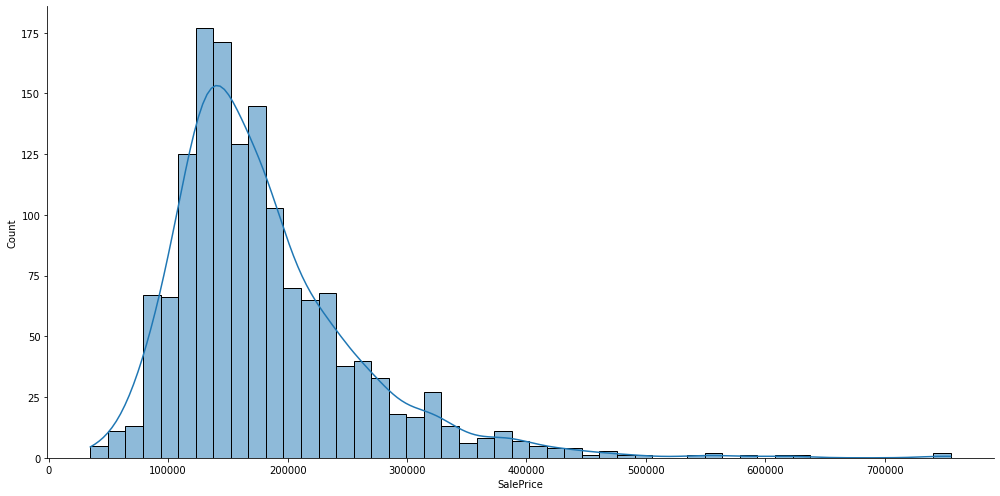

In [114]:
# Distribution

sns.displot(train['SalePrice'], kde=True, height=7, aspect=2)

## Explore numerical features

In [169]:
train_num = train[features_numeric]

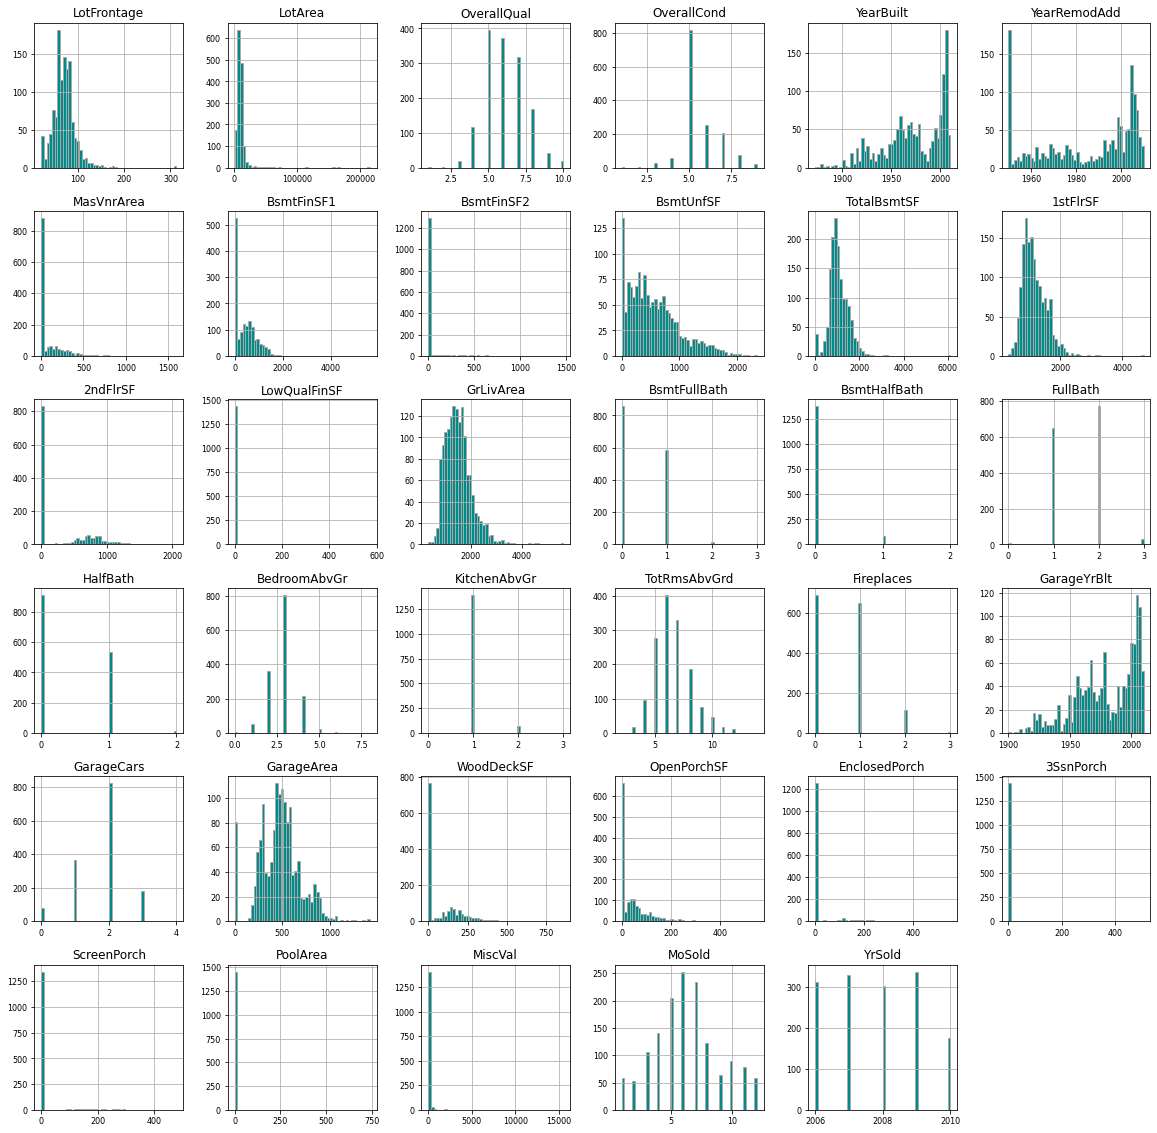

In [172]:
# Massive Vizualisation of numerical features
# There are a few columns where we could potentially apply logarithm later : LotFrontage, LotArea, MasVnrArea...

fig_ = train_num.hist(figsize=(20, 20), bins=50, color="darkcyan", edgecolor="darkgray", xlabelsize=8, ylabelsize=8)

In [209]:
# R² + heatmap with SalePrice. Let's add SalePrice
train_num2 = pd.concat([train_num, train['SalePrice']], axis=1)

# Define the correlation matrix
train_corr_matrix = train_num2.corr()

# Let's print all the correlations with SalePrice
print(train_corr_matrix.loc['SalePrice'])

LotFrontage      0.35
LotArea          0.26
OverallQual      0.79
OverallCond     -0.08
YearBuilt        0.52
YearRemodAdd     0.51
MasVnrArea       0.48
BsmtFinSF1       0.39
BsmtFinSF2      -0.01
BsmtUnfSF        0.21
TotalBsmtSF      0.61
1stFlrSF         0.61
2ndFlrSF         0.32
LowQualFinSF    -0.03
GrLivArea        0.71
BsmtFullBath     0.23
BsmtHalfBath    -0.02
FullBath         0.56
HalfBath         0.28
BedroomAbvGr     0.17
KitchenAbvGr    -0.14
TotRmsAbvGrd     0.53
Fireplaces       0.47
GarageYrBlt      0.49
GarageCars       0.64
GarageArea       0.62
WoodDeckSF       0.32
OpenPorchSF      0.32
EnclosedPorch   -0.13
3SsnPorch        0.04
ScreenPorch      0.11
PoolArea         0.09
MiscVal         -0.02
MoSold           0.05
YrSold          -0.03
SalePrice        1.00
Name: SalePrice, dtype: float64


In [210]:
# For the sake of curiosity, let's focus of the effect of applying log in Feature Engineering.
# We know that correlation between SalePrice and LotArea is 0.26
# What would happen if we applied logarithm on LotArea and calculate again correlation ?
train_num2['LotArea_log'] = train_num2['LotArea'].apply(np.log1p)

# Define the correlation matrix
train_corr_matrix2 = train_num2.corr()

print(train_corr_matrix2.loc['SalePrice'].loc['LotArea_log'])


0.3885283824240981


In [211]:
# The correlation increase from 0.26 to 0.39 !

# But we will study all of these things in phase 3 - Feature Engineering :)
train_num2 = train_num2.drop(['LotArea_log'], axis=1)

In [231]:
# Select the vector representing the correlation of all numerical features with SalePrice
# [:-1] to remove the column SalePrice
df_num_corr = train_corr_matrix.loc['SalePrice'][:-1]

# And select the features the best correlated with SalePrice
strong_features_display = df_num_corr[abs(df_num_corr)>=0.5].sort_values(ascending=False)
slight_features_display = df_num_corr[(abs(df_num_corr)<0.5) & (abs(df_num_corr)>=0.3)].sort_values(ascending=False)

print(f"{len(strong_features_display)} strong correlated features :")
print(strong_features_display)
print("")
print(f"{len(slight_features_display)} slight correlated features")
print(slight_features_display)

# Bind to lists
strong_features = strong_features_display.index.tolist()
slight_features = slight_features_display.index.tolist()



10 strong correlated features :
OverallQual    0.79
GrLivArea      0.71
GarageCars     0.64
GarageArea     0.62
TotalBsmtSF    0.61
1stFlrSF       0.61
FullBath       0.56
TotRmsAbvGrd   0.53
YearBuilt      0.52
YearRemodAdd   0.51
Name: SalePrice, dtype: float64

8 slight correlated features
GarageYrBlt   0.49
MasVnrArea    0.48
Fireplaces    0.47
BsmtFinSF1    0.39
LotFrontage   0.35
WoodDeckSF    0.32
2ndFlrSF      0.32
OpenPorchSF   0.32
Name: SalePrice, dtype: float64


<Figure size 3600x3600 with 0 Axes>

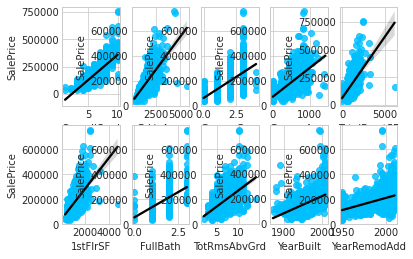

In [248]:
# Scatterplots of strong correlated correlated with SalePrice. Link with business value.
plt.figure(figsize=(50,50))
plt.style.use("seaborn-whitegrid")  # define figures style
#fig, ax = plt.subplots(math.ceil(len(strong_features) / 3), 3) # Grid 4*3 = 12, enough for the 10 strong features

fig, ax = plt.subplots(2, 5) # Grid 4*3 = 12, enough for the 10 strong features


for i, ax in enumerate(fig.axes):
    # plot the correlation of each feature with SalePrice
    if i < len(strong_features):
        sns.regplot(x=strong_features[i], y="SalePrice", data=train, ax=ax, scatter_kws={
                        "color": "deepskyblue"}, line_kws={"color": "black"})
                    


## Explore categorical features

In [119]:
# Massive Vizualisation

In [120]:
# Drop quasi-constant

In [121]:
# Vizualise the best-correlated with SalePrice (boxplot). Link with business value

## Clean the best correlated features

In [122]:
# Handle missing data for numerical features

In [123]:
# Handle missing data for categorical features

## Modelization

In [124]:
# ... to be continued

# Phase 3 - Feature Engineering

> Placeholder : Why ?

## Correlation matrix between all variables.

(We will have to study interactions later)

<AxesSubplot:title={'center':'Correlation of all variables'}>

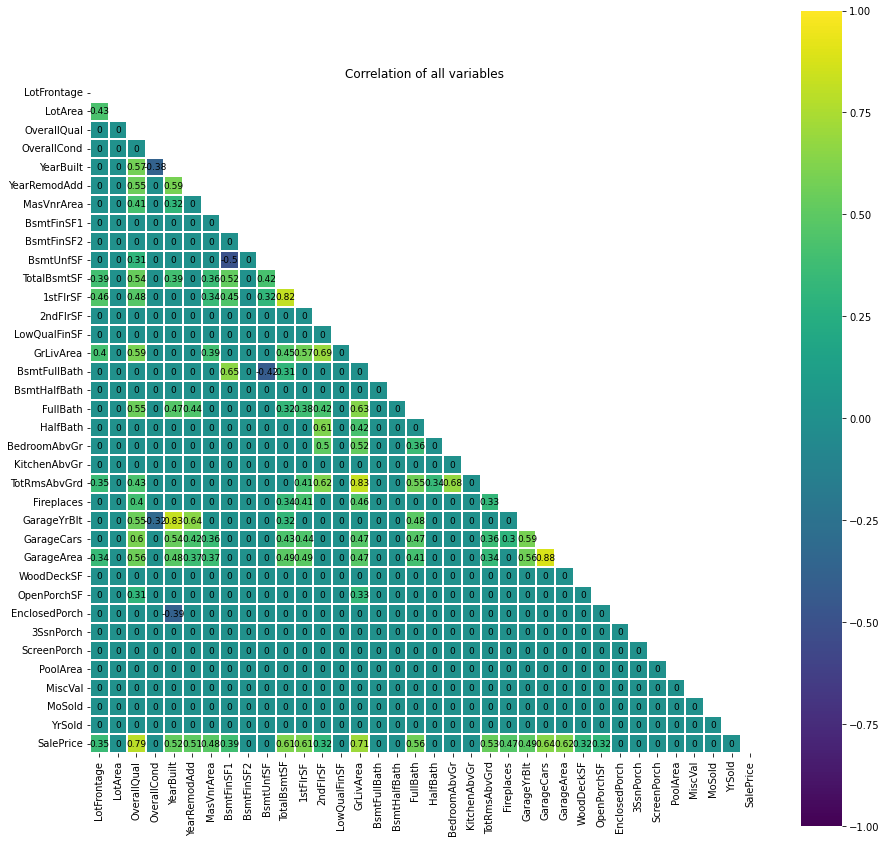

In [183]:
# Replace correlation < |0.3| by 0 for a better visibility
train_corr_matrix[(train_corr_matrix < 0.3) & (train_corr_matrix > -0.3)] = 0

# Correlation matrix as Heatmap
pd.options.display.float_format = "{:,.2f}".format
# Set the width and height of the figure
plt.figure(figsize=(15, 15))

# Add title
plt.title("Correlation of all variables")

# Mask the upper part of the heatmap
mask = np.triu(np.ones_like(train_corr_matrix, dtype=bool))

# Choose the color map
cmap = "viridis"

# plot the heatmap
sns.heatmap(train_corr_matrix, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 9, "color": "black"}, square=True, cmap=cmap, annot=True)